# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count', 'synonyms_count',
                  'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

## 2 Susceptibility in absolute and sentence-relative values

Build our data.

In [3]:
model = Model(time=Time.continuous, source=Source.all, past=Past.all, durl=Durl.exclude_past, max_distance=1)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        # Prepare these arrays for stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        
        for feature in Substitution.__features__:
            sentence_values, _ = substitution.source_destination_features(feature)
            sentence_values_rel, _ = substitution.source_destination_features(
                feature, sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            # Stopword-check the arrays.
            words = getattr(substitution.source, source_type)[dslice]
            for i, (word, lemma, token, tag) in enumerate(zip(words, lemmas, tokens, tags)):
                if (token in stopwords) or (lemma in stopwords):
                    # Drop stopwords from this analysis since we exclude stopword-substitutions.
                    continue
                data.append({'cluster_id': substitution.source.cluster.sid,
                             'destination_id': substitution.destination.sid,
                             'occurrence': substitution.occurrence,
                             'source_id': substitution.source.sid,
                             'feature': feature,
                             'word': word,
                             'POS': tag,
                             'target': i == substitution.position,
                             'value': sentence_values[i],
                             'value_rel': sentence_values_rel[i]})

original_susties = pd.DataFrame(data)
del data

Got 2796 substitutions for model Model(time=Time.continuous, source=Source.all, past=Past.all, durl=Durl.exclude_past, max_distance=1)


  0% (   1 of 2796) |                      | Elapsed Time: 0:00:04 ETA:  3:48:23

  1% (  35 of 2796) |                      | Elapsed Time: 0:00:05 ETA:  0:01:17

  2% (  70 of 2796) |                      | Elapsed Time: 0:00:06 ETA:  0:01:16

  3% ( 105 of 2796) |                      | Elapsed Time: 0:00:07 ETA:  0:01:12

  4% ( 123 of 2796) |                      | Elapsed Time: 0:00:08 ETA:  0:01:22

  5% ( 140 of 2796) |#                     | Elapsed Time: 0:00:09 ETA:  0:01:22

  6% ( 175 of 2796) |#                     | Elapsed Time: 0:00:10 ETA:  0:01:13

  7% ( 210 of 2796) |#                     | Elapsed Time: 0:00:10 ETA:  0:01:03

  8% ( 245 of 2796) |#                     | Elapsed Time: 0:00:10 ETA:  0:00:54

 10% ( 280 of 2796) |##                    | Elapsed Time: 0:00:11 ETA:  0:00:50

 11% ( 315 of 2796) |##                    | Elapsed Time: 0:00:11 ETA:  0:00:44

 12% ( 350 of 2796) |##                    | Elapsed Time: 0:00:12 ETA:  0:00:44

 13% ( 385 of 2796) |###                   | Elapsed Time: 0:00:13 ETA:  0:00:38

 15% ( 420 of 2796) |###                   | Elapsed Time: 0:00:13 ETA:  0:00:31

 16% ( 455 of 2796) |###                   | Elapsed Time: 0:00:14 ETA:  0:00:27

 17% ( 490 of 2796) |###                   | Elapsed Time: 0:00:14 ETA:  0:00:25

 18% ( 525 of 2796) |####                  | Elapsed Time: 0:00:15 ETA:  0:00:26

 20% ( 560 of 2796) |####                  | Elapsed Time: 0:00:15 ETA:  0:00:26

 21% ( 595 of 2796) |####                  | Elapsed Time: 0:00:16 ETA:  0:00:26

 22% ( 630 of 2796) |####                  | Elapsed Time: 0:00:16 ETA:  0:00:25

 23% ( 665 of 2796) |#####                 | Elapsed Time: 0:00:17 ETA:  0:00:22

 25% ( 700 of 2796) |#####                 | Elapsed Time: 0:00:17 ETA:  0:00:23

 26% ( 734 of 2796) |#####                 | Elapsed Time: 0:00:18 ETA:  0:00:21

 27% ( 769 of 2796) |######                | Elapsed Time: 0:00:18 ETA:  0:00:23

 28% ( 804 of 2796) |######                | Elapsed Time: 0:00:19 ETA:  0:00:25

 30% ( 839 of 2796) |######                | Elapsed Time: 0:00:20 ETA:  0:00:24

 31% ( 874 of 2796) |######                | Elapsed Time: 0:00:20 ETA:  0:00:26

 32% ( 909 of 2796) |#######               | Elapsed Time: 0:00:21 ETA:  0:00:26

 33% ( 944 of 2796) |#######               | Elapsed Time: 0:00:22 ETA:  0:00:28

 35% ( 979 of 2796) |#######               | Elapsed Time: 0:00:23 ETA:  0:00:29

 36% (1014 of 2796) |#######               | Elapsed Time: 0:00:23 ETA:  0:00:28

 37% (1049 of 2796) |########              | Elapsed Time: 0:00:23 ETA:  0:00:28

 38% (1069 of 2796) |########              | Elapsed Time: 0:00:24 ETA:  0:00:31

 38% (1084 of 2796) |########              | Elapsed Time: 0:00:25 ETA:  0:00:36

 39% (1101 of 2796) |########              | Elapsed Time: 0:00:26 ETA:  0:00:44

 40% (1119 of 2796) |########              | Elapsed Time: 0:00:27 ETA:  0:00:44

 41% (1154 of 2796) |#########             | Elapsed Time: 0:00:28 ETA:  0:00:52

 42% (1189 of 2796) |#########             | Elapsed Time: 0:00:29 ETA:  0:00:49

 43% (1224 of 2796) |#########             | Elapsed Time: 0:00:29 ETA:  0:00:53

 45% (1259 of 2796) |#########             | Elapsed Time: 0:00:30 ETA:  0:00:52

 46% (1294 of 2796) |##########            | Elapsed Time: 0:00:30 ETA:  0:00:38

 47% (1329 of 2796) |##########            | Elapsed Time: 0:00:31 ETA:  0:00:27

 48% (1364 of 2796) |##########            | Elapsed Time: 0:00:32 ETA:  0:00:29

 50% (1399 of 2796) |###########           | Elapsed Time: 0:00:33 ETA:  0:00:18

 51% (1433 of 2796) |###########           | Elapsed Time: 0:00:33 ETA:  0:00:17

 52% (1468 of 2796) |###########           | Elapsed Time: 0:00:34 ETA:  0:00:18

 53% (1503 of 2796) |###########           | Elapsed Time: 0:00:34 ETA:  0:00:17

 55% (1538 of 2796) |############          | Elapsed Time: 0:00:35 ETA:  0:00:19

 56% (1573 of 2796) |############          | Elapsed Time: 0:00:36 ETA:  0:00:20

 57% (1608 of 2796) |############          | Elapsed Time: 0:00:36 ETA:  0:00:11

 58% (1643 of 2796) |############          | Elapsed Time: 0:00:37 ETA:  0:00:12

 60% (1678 of 2796) |#############         | Elapsed Time: 0:00:38 ETA:  0:00:16

 61% (1713 of 2796) |#############         | Elapsed Time: 0:00:39 ETA:  0:00:25

 62% (1748 of 2796) |#############         | Elapsed Time: 0:00:40 ETA:  0:00:25

 63% (1783 of 2796) |##############        | Elapsed Time: 0:00:41 ETA:  0:00:21

 65% (1818 of 2796) |##############        | Elapsed Time: 0:00:41 ETA:  0:00:22

 66% (1853 of 2796) |##############        | Elapsed Time: 0:00:45 ETA:  0:01:03

 66% (1868 of 2796) |##############        | Elapsed Time: 0:00:47 ETA:  0:01:13

 67% (1888 of 2796) |##############        | Elapsed Time: 0:00:47 ETA:  0:01:06

 68% (1923 of 2796) |###############       | Elapsed Time: 0:00:48 ETA:  0:01:06

 70% (1958 of 2796) |###############       | Elapsed Time: 0:00:49 ETA:  0:00:57

 71% (1993 of 2796) |###############       | Elapsed Time: 0:00:50 ETA:  0:00:57

 72% (2028 of 2796) |###############       | Elapsed Time: 0:00:50 ETA:  0:00:56

 73% (2063 of 2796) |################      | Elapsed Time: 0:00:51 ETA:  0:00:57

 75% (2098 of 2796) |################      | Elapsed Time: 0:00:52 ETA:  0:00:22

 76% (2132 of 2796) |################      | Elapsed Time: 0:00:52 ETA:  0:00:19

 77% (2167 of 2796) |#################     | Elapsed Time: 0:00:53 ETA:  0:00:03

 78% (2202 of 2796) |#################     | Elapsed Time: 0:00:53 ETA:  0:00:02

 80% (2237 of 2796) |#################     | Elapsed Time: 0:00:54 ETA:  0:00:00

 81% (2272 of 2796) |#################     | Elapsed Time: 0:00:54 ETA:  0:00:00

 82% (2307 of 2796) |##################    | Elapsed Time: 0:00:55 ETA:  0:00:00

 83% (2342 of 2796) |##################    | Elapsed Time: 0:00:55 ETA:  0:00:00

 85% (2377 of 2796) |##################    | Elapsed Time: 0:00:56 ETA:  0:00:00

 86% (2412 of 2796) |##################    | Elapsed Time: 0:00:56 ETA:  0:00:00

 87% (2447 of 2796) |###################   | Elapsed Time: 0:00:56 ETA:  0:00:00

 88% (2482 of 2796) |###################   | Elapsed Time: 0:00:57 ETA:  0:00:00

 90% (2517 of 2796) |###################   | Elapsed Time: 0:00:57 ETA:  0:00:00

 91% (2552 of 2796) |####################  | Elapsed Time: 0:00:58 ETA:  0:00:00

 92% (2587 of 2796) |####################  | Elapsed Time: 0:00:58 ETA:  0:00:00

 93% (2622 of 2796) |####################  | Elapsed Time: 0:00:59 ETA:  0:00:00

 95% (2657 of 2796) |####################  | Elapsed Time: 0:00:59 ETA:  0:00:00

 96% (2692 of 2796) |##################### | Elapsed Time: 0:01:00 ETA:  0:00:00

 97% (2727 of 2796) |##################### | Elapsed Time: 0:01:00 ETA:  0:00:00

 98% (2762 of 2796) |##################### | Elapsed Time: 0:01:00 ETA:  0:00:00

100% (2796 of 2796) |######################| Elapsed Time: 0:01:01 Time: 0:01:01


Assign proper weight to each substitution.

In [4]:
susty_words = original_susties.copy()
divide_target_sum = lambda x: x / (susty_words.loc[x.index].target *
                                   susty_words.loc[x.index].weight).sum()

# Weight is 1, at first.
susty_words['weight'] = 1
# Divided by the number of substitutions that share a durl.
susty_words['weight'] = susty_words\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_target_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_target_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
susty_words['weight'] = susty_words\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_target_sum)

# Finally, add a weight measure for word appearances that we use in the POS analysis,
# weighing a word by the number of words that appear with it in its sentence.
susty_words['weight_appeared'] = susty_words\
    .groupby(['source_id', 'destination_id', 'occurrence', 'feature'])['weight']\
    .transform(lambda x: x / len(x))

Compute susceptibility for each feature value and each feature sentence_relative value.

In [5]:
susty = lambda x: ((x * susty_words.loc[x.index, 'weight']).sum() /
                   susty_words.loc[x.index, 'weight'].sum())
susties = susty_words\
    .groupby(['feature', 'value'], as_index=False)['target']\
    .aggregate({'susty': susty})
susties_rel = susty_words\
    .groupby(['feature', 'value_rel'], as_index=False)['target']\
    .aggregate({'susty': susty})\
    .rename(columns={'value_rel': 'value'})

Bin and plot susceptibilities for each feature, in absolute value and sentence-relative.

In [6]:
def plot_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    x = data['value']
    s = data['susty']
    
    # Compute binning.
    x_bins, bins = pd.cut(x, BIN_COUNT, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    heights = np.zeros(BIN_COUNT)
    cis = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = s[x_bins == i].mean()
        cis[i] = 1.96 * s[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    sigmaphi = r'\sigma_{/phi' + (',r' if relative else '') + '}'
    plt.plot(middles, heights, '-', lw=2, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, heights - cis, heights + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, .5)

### 2.1 All feature susceptibilities

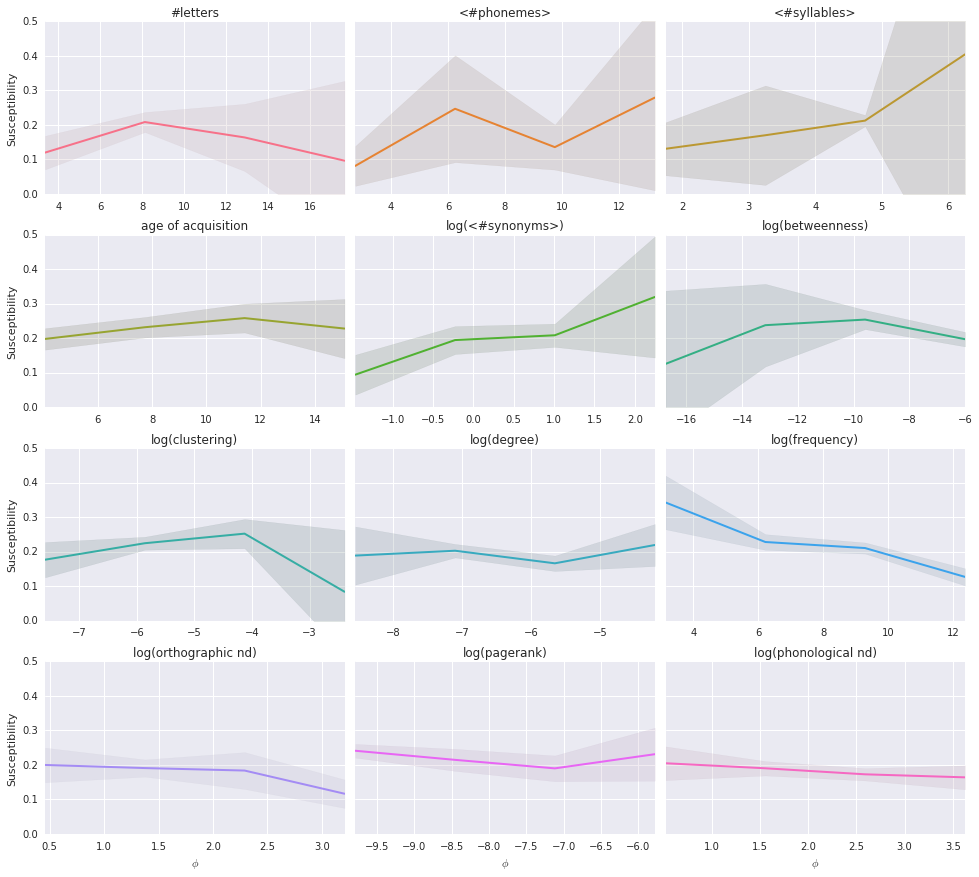

In [7]:
ordered_features = sorted(Substitution.__features__,
                          key=lambda f: Substitution._transformed_feature(f).__doc__)
g = sb.FacetGrid(data=susties, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

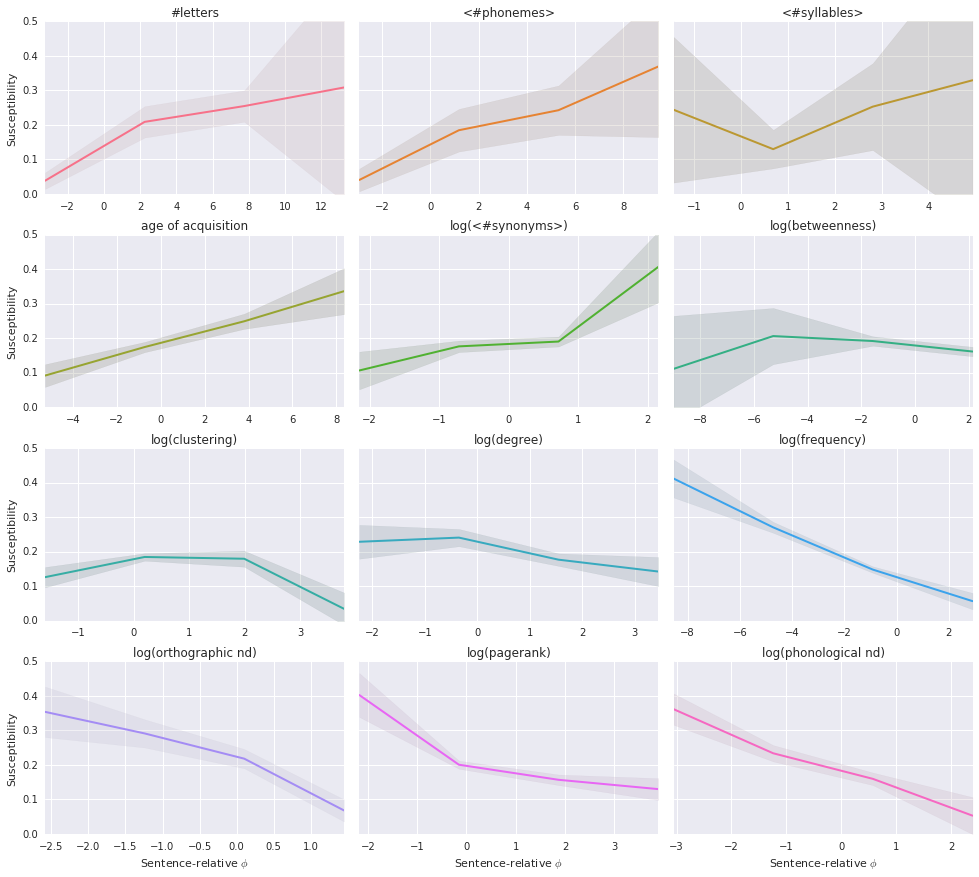

In [8]:
g = sb.FacetGrid(data=susties_rel, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on how confidence intervals are computed here**

There are three ways I can conceive of the computation represented in the graphs above:
1. For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.
2. Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. This is the way CIs are computed above.
3. Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values. So for now I'm sticking with (2).

### 2.2 Feature susceptibilities, reduced to features we expose in the paper

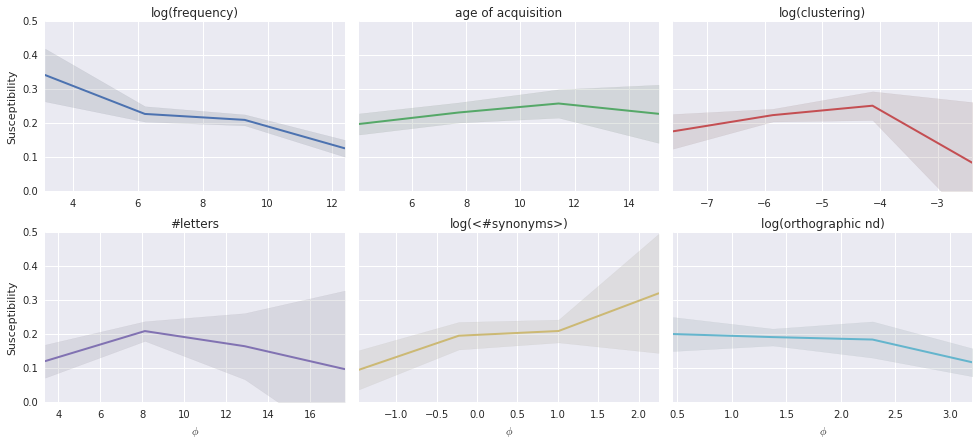

In [9]:
g = sb.FacetGrid(data=susties[susties['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

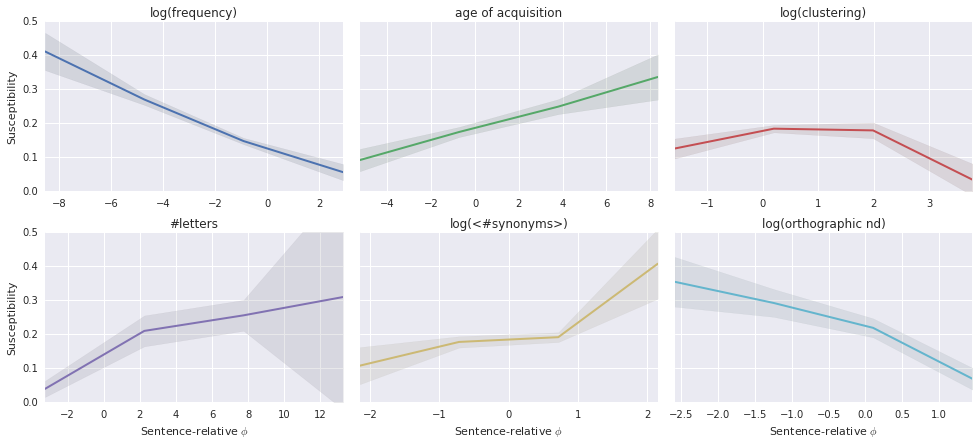

In [10]:
g = sb.FacetGrid(data=susties_rel[susties_rel['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

## 3 On which POS tags do substitutions fall?

In [11]:
poses = susty_words[susty_words.feature == 'aoa'][['POS', 'cluster_id', 'destination_id',
                                                   'occurrence', 'source_id', 'target',
                                                   'weight', 'weight_appeared', 'word']]
# Only take first letter of POS code to denote categories,
# and group stopword-like categories together.
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']
poses['rPOS'] = poses['POS']\
    .apply(lambda x: x[0])\
    .apply(lambda x: 'Stopword-like' if x in stop_poses else x)

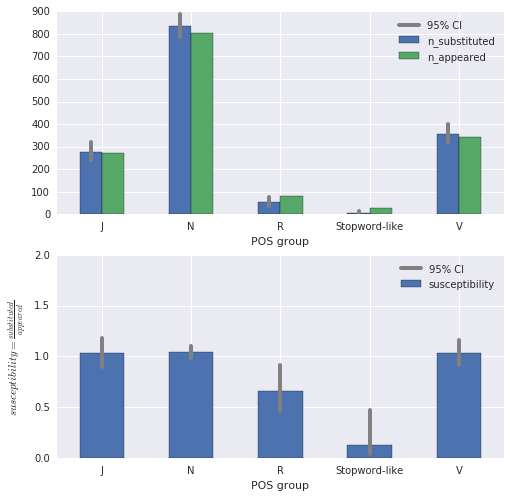

In [12]:
# Compute POS counts.
susty_pos = lambda x: ((x * poses.loc[x.index, 'weight']).sum() /
                       poses.loc[x.index, 'weight_appeared'].sum())
susties_pos = poses.groupby('rPOS')['target'].aggregate(
    {'susceptibility': susty_pos,
     'n_substituted': lambda x: (x * poses.loc[x.index, 'weight']).sum(),
     'n_appeared': lambda x: poses.loc[x.index, 'weight_appeared'].sum()}
).rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']].plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(), method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted, lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility'].plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], cis[i] * total_substituted / susties_pos.n_appeared.iloc[i],
                 lw=4, color='grey', label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-pos_susceptibilities'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [13]:
# Test the n_substituted proportions are different from the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['R', 'Stopword-like']


## 4 Susceptibility in terms of absolute fractiles

In [14]:
def plot_absolute_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')

    # Compute feature bins.
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            x_fractiles = pd.qcut(data.value, bin_count, labels=False)
            break
        except ValueError:
            pass

    # Compute bin counts
    heights = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = data[data.target & (x_fractiles == i)].weight.sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, bin_count + 1), heights, color=color)
    plt.fill_between(range(1, bin_count + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, bin_count + 1))
    plt.xlim(1, bin_count)
    plt.ylim(0, None)

### 4.1 All features susceptibilities

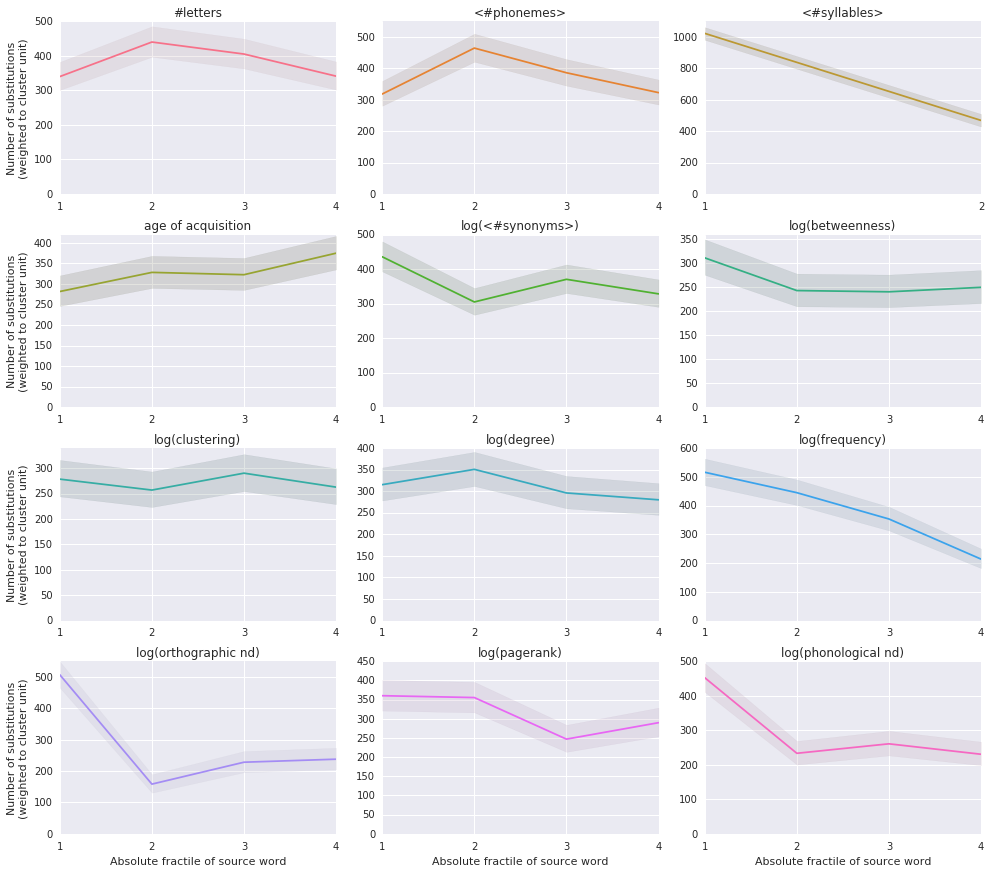

In [15]:
# Now plot.
g = sb.FacetGrid(data=susty_words, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're again in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all absolute feature fractiles are available to sample from in all the sentences. Again, there's no way out of this, so we're going to use multinomial CIs.

### 4.2 Feature susceptibilities, reduced to features we expose in the paper

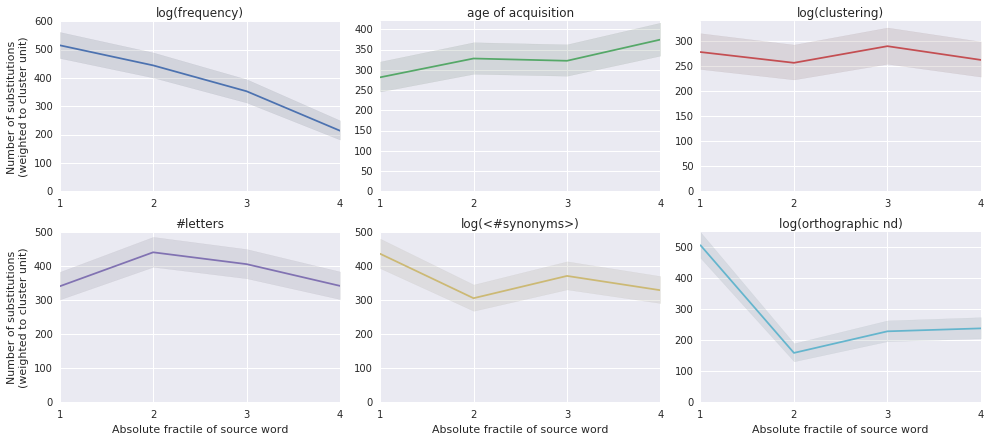

In [16]:
# Now plot.
g = sb.FacetGrid(data=susty_words[susty_words['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

## 5 Susceptibility in terms of sentence fractiles

Build our data.

In [17]:
data = []
for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, _ = substitution.features(feature)
            if np.isnan(source):
                # The source word has no feature value. We drop this substitution.
                continue
            sentence, _ = substitution.source_destination_features(feature)
            # Remove stopwords from this analysis, since we dropped substitutions on stopwords.
            dslice = slice(substitution.start,
                           substitution.start + len(substitution.destination.tokens))
            is_stopword = np.array([(lemma in stopwords) or (token in stopwords)
                                    for (lemma, token) in
                                    zip(substitution.source.lemmas[dslice],
                                        substitution.source.tokens[dslice])])
            sentence[is_stopword] = np.nan
            # Find the number of bins we'll use.
            values = set(sentence[np.isfinite(sentence)])
            if len(values) == 0 or len(values) == 1:
                # Only NaNs, or only one feature value. Drop this.
                continue
            start, stop = None, None
            power = 0
            while start is None:
                if int(BIN_COUNT / 2**power) * 2**power != BIN_COUNT:
                    raise ValueError('BIN_COUNT must be a power of 2')
                try:
                    start = 2**power * pd.qcut(sentence, int(BIN_COUNT / 2**power),
                                               labels=False)[substitution.position]
                    stop = start + 2**power
                except ValueError:
                    power += 1
            # And finally save the bin.
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'feature': feature,
                         'start': start,
                         'stop': stop})

original_fractiles = pd.DataFrame(data)
del data

  1% (  35 of 2796) |                      | Elapsed Time: 0:00:00 ETA:  0:00:30

  2% (  70 of 2796) |                      | Elapsed Time: 0:00:00 ETA:  0:00:38

  3% ( 105 of 2796) |                      | Elapsed Time: 0:00:01 ETA:  0:00:34

  5% ( 140 of 2796) |#                     | Elapsed Time: 0:00:01 ETA:  0:00:33

  6% ( 175 of 2796) |#                     | Elapsed Time: 0:00:02 ETA:  0:00:32

  7% ( 210 of 2796) |#                     | Elapsed Time: 0:00:02 ETA:  0:00:30

  8% ( 245 of 2796) |#                     | Elapsed Time: 0:00:02 ETA:  0:00:29

 10% ( 280 of 2796) |##                    | Elapsed Time: 0:00:03 ETA:  0:00:28

 11% ( 315 of 2796) |##                    | Elapsed Time: 0:00:03 ETA:  0:00:27

 12% ( 350 of 2796) |##                    | Elapsed Time: 0:00:03 ETA:  0:00:27

 13% ( 385 of 2796) |###                   | Elapsed Time: 0:00:04 ETA:  0:00:26

 15% ( 420 of 2796) |###                   | Elapsed Time: 0:00:04 ETA:  0:00:26

 16% ( 455 of 2796) |###                   | Elapsed Time: 0:00:05 ETA:  0:00:25

 17% ( 490 of 2796) |###                   | Elapsed Time: 0:00:05 ETA:  0:00:24

 18% ( 525 of 2796) |####                  | Elapsed Time: 0:00:05 ETA:  0:00:24

 20% ( 560 of 2796) |####                  | Elapsed Time: 0:00:06 ETA:  0:00:24

 21% ( 595 of 2796) |####                  | Elapsed Time: 0:00:06 ETA:  0:00:24

 22% ( 630 of 2796) |####                  | Elapsed Time: 0:00:07 ETA:  0:00:24

 23% ( 665 of 2796) |#####                 | Elapsed Time: 0:00:07 ETA:  0:00:24

 25% ( 700 of 2796) |#####                 | Elapsed Time: 0:00:07 ETA:  0:00:23

 26% ( 734 of 2796) |#####                 | Elapsed Time: 0:00:08 ETA:  0:00:22

 27% ( 769 of 2796) |######                | Elapsed Time: 0:00:08 ETA:  0:00:22

 28% ( 804 of 2796) |######                | Elapsed Time: 0:00:09 ETA:  0:00:22

 30% ( 839 of 2796) |######                | Elapsed Time: 0:00:09 ETA:  0:00:22

 31% ( 874 of 2796) |######                | Elapsed Time: 0:00:09 ETA:  0:00:22

 32% ( 909 of 2796) |#######               | Elapsed Time: 0:00:10 ETA:  0:00:22

 33% ( 944 of 2796) |#######               | Elapsed Time: 0:00:10 ETA:  0:00:21

 35% ( 979 of 2796) |#######               | Elapsed Time: 0:00:11 ETA:  0:00:20

 36% (1014 of 2796) |#######               | Elapsed Time: 0:00:11 ETA:  0:00:19

 37% (1049 of 2796) |########              | Elapsed Time: 0:00:11 ETA:  0:00:19

 38% (1084 of 2796) |########              | Elapsed Time: 0:00:12 ETA:  0:00:19

 40% (1119 of 2796) |########              | Elapsed Time: 0:00:12 ETA:  0:00:17

 41% (1154 of 2796) |#########             | Elapsed Time: 0:00:12 ETA:  0:00:17

 42% (1189 of 2796) |#########             | Elapsed Time: 0:00:13 ETA:  0:00:16

 43% (1224 of 2796) |#########             | Elapsed Time: 0:00:13 ETA:  0:00:15

 45% (1259 of 2796) |#########             | Elapsed Time: 0:00:13 ETA:  0:00:15

 46% (1294 of 2796) |##########            | Elapsed Time: 0:00:14 ETA:  0:00:14

 47% (1329 of 2796) |##########            | Elapsed Time: 0:00:14 ETA:  0:00:14

 48% (1364 of 2796) |##########            | Elapsed Time: 0:00:15 ETA:  0:00:13

 50% (1399 of 2796) |###########           | Elapsed Time: 0:00:15 ETA:  0:00:13

 51% (1433 of 2796) |###########           | Elapsed Time: 0:00:15 ETA:  0:00:13

 52% (1468 of 2796) |###########           | Elapsed Time: 0:00:16 ETA:  0:00:12

 53% (1503 of 2796) |###########           | Elapsed Time: 0:00:16 ETA:  0:00:12

 55% (1538 of 2796) |############          | Elapsed Time: 0:00:16 ETA:  0:00:12

 56% (1573 of 2796) |############          | Elapsed Time: 0:00:17 ETA:  0:00:12

 57% (1608 of 2796) |############          | Elapsed Time: 0:00:17 ETA:  0:00:11

 58% (1643 of 2796) |############          | Elapsed Time: 0:00:18 ETA:  0:00:11

 60% (1678 of 2796) |#############         | Elapsed Time: 0:00:18 ETA:  0:00:11

 61% (1713 of 2796) |#############         | Elapsed Time: 0:00:18 ETA:  0:00:10

 62% (1748 of 2796) |#############         | Elapsed Time: 0:00:19 ETA:  0:00:10

 63% (1783 of 2796) |##############        | Elapsed Time: 0:00:19 ETA:  0:00:09

 65% (1818 of 2796) |##############        | Elapsed Time: 0:00:19 ETA:  0:00:09

 66% (1853 of 2796) |##############        | Elapsed Time: 0:00:20 ETA:  0:00:08

 67% (1888 of 2796) |##############        | Elapsed Time: 0:00:20 ETA:  0:00:08

 68% (1923 of 2796) |###############       | Elapsed Time: 0:00:20 ETA:  0:00:07

 70% (1958 of 2796) |###############       | Elapsed Time: 0:00:21 ETA:  0:00:07

 71% (1993 of 2796) |###############       | Elapsed Time: 0:00:21 ETA:  0:00:06

 72% (2028 of 2796) |###############       | Elapsed Time: 0:00:21 ETA:  0:00:06

 73% (2063 of 2796) |################      | Elapsed Time: 0:00:22 ETA:  0:00:06

 75% (2098 of 2796) |################      | Elapsed Time: 0:00:22 ETA:  0:00:05

 76% (2132 of 2796) |################      | Elapsed Time: 0:00:23 ETA:  0:00:04

 77% (2167 of 2796) |#################     | Elapsed Time: 0:00:23 ETA:  0:00:04

 78% (2202 of 2796) |#################     | Elapsed Time: 0:00:23 ETA:  0:00:04

 80% (2237 of 2796) |#################     | Elapsed Time: 0:00:24 ETA:  0:00:04

 81% (2272 of 2796) |#################     | Elapsed Time: 0:00:24 ETA:  0:00:04

 82% (2307 of 2796) |##################    | Elapsed Time: 0:00:24 ETA:  0:00:03

 83% (2342 of 2796) |##################    | Elapsed Time: 0:00:25 ETA:  0:00:03

 85% (2377 of 2796) |##################    | Elapsed Time: 0:00:25 ETA:  0:00:03

 86% (2412 of 2796) |##################    | Elapsed Time: 0:00:25 ETA:  0:00:02

 87% (2447 of 2796) |###################   | Elapsed Time: 0:00:26 ETA:  0:00:08

 88% (2482 of 2796) |###################   | Elapsed Time: 0:00:27 ETA:  0:00:08

 90% (2517 of 2796) |###################   | Elapsed Time: 0:00:27 ETA:  0:00:08

 91% (2552 of 2796) |####################  | Elapsed Time: 0:00:28 ETA:  0:00:08

 92% (2587 of 2796) |####################  | Elapsed Time: 0:00:28 ETA:  0:00:07

 93% (2622 of 2796) |####################  | Elapsed Time: 0:00:28 ETA:  0:00:07

 95% (2657 of 2796) |####################  | Elapsed Time: 0:00:29 ETA:  0:00:07

 96% (2692 of 2796) |##################### | Elapsed Time: 0:00:29 ETA:  0:00:07

 97% (2727 of 2796) |##################### | Elapsed Time: 0:00:29 ETA:  0:00:00

 98% (2762 of 2796) |##################### | Elapsed Time: 0:00:30 ETA:  0:00:00

100% (2796 of 2796) |######################| Elapsed Time: 0:00:30 Time: 0:00:30


Compute the weight of each substitution, according to what other substitutions it's pooled with, and the size of its bin. Letting:
* $n_d(i) = \#\text{substitutions with same durl as substitution }i$
* and $n_c(i) = \#\text{substitutions with same cluster as substitution }i$ (counting substitutions with the same durl as one)
* $p(i) = \text{precision (width) of the bin we assigned to substitution }i$

Then we define the weight of a substitution $i$:
$$w(i) = \frac{1}{n_d(i) n_c(i) p(i)}$$

In [18]:
fractiles = original_fractiles.copy()
divide_sum = lambda x: x / x.sum()

# Weight is 1 at first.
fractiles['weight'] = 1
# Divided by the number of substitutions that share a durl.
fractiles['weight'] = fractiles\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
fractiles['weight'] = fractiles\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_sum)
# And finally divide by the precision of the bin we put a substitution in.
fractiles['weight'] = fractiles['weight'] / (fractiles['stop'] - fractiles['start'])

Now for each feature, count the sum of weights in each bin and plot that.

In [19]:
def plot_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = data[(data['start'] <= i) & (i < data['stop'])]['weight'].sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, BIN_COUNT + 1), heights, color=color)
    plt.fill_between(range(1, BIN_COUNT + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, BIN_COUNT + 1))
    plt.ylim(0, None)

### 5.1 All features susceptibilities

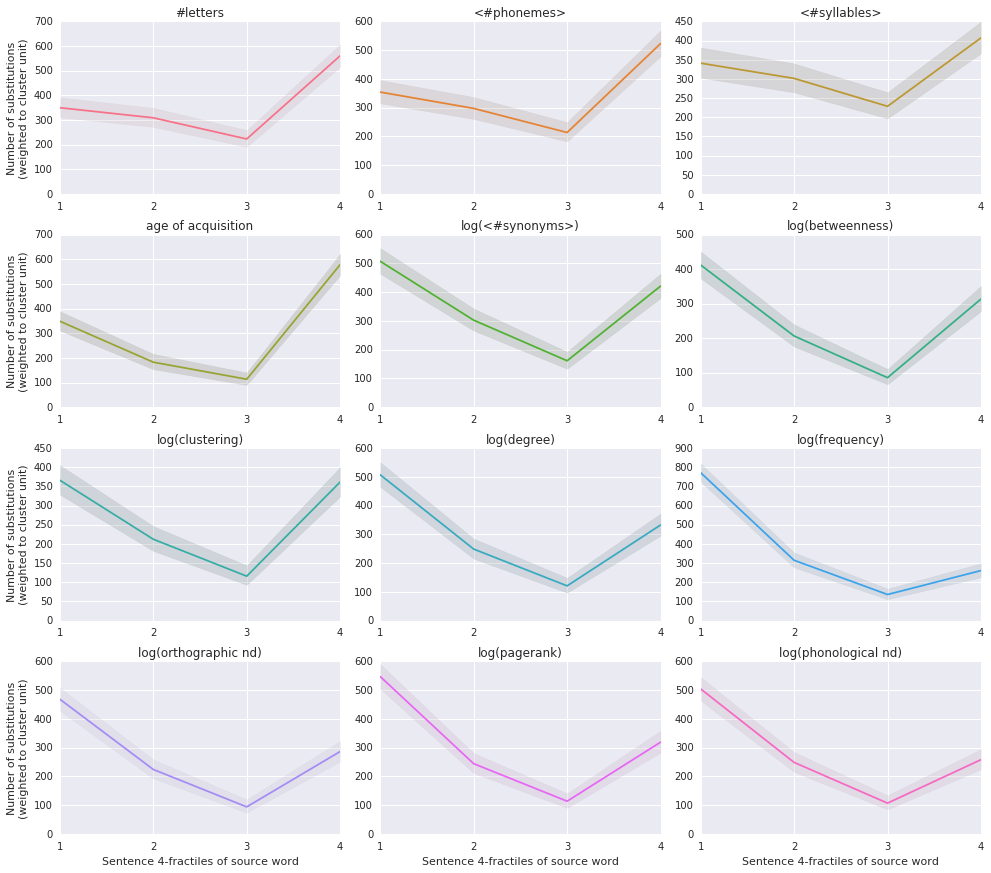

In [20]:
# Now plot.
g = sb.FacetGrid(data=fractiles, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're finally in a real multinomial sampling (and it's the only time). So we're going to use multinomial CIs.

### 5.2 Feature susceptibilities, reduced to features we expose in the paper

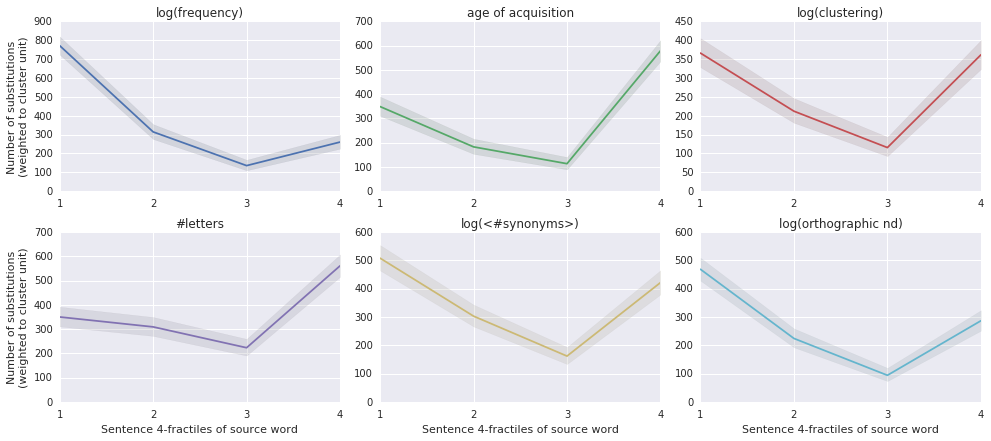

In [21]:
# Now plot.
g = sb.FacetGrid(data=fractiles[fractiles['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)